<a href="https://colab.research.google.com/github/LuppeCh/F1EDA/blob/Graficos-7%2F8%2F9/Exploraci%C3%B3n_de_Datos_Trabajo_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
install.packages("dplyr")
install.packages("ggplot2")
install.packages("gridExtra")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in install.packages("ggplot2"):
“installation of package ‘ggplot2’ had non-zero exit status”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
library(dplyr)
library(ggplot2)
library(tidyr)
library(gridExtra)
library(grid)

In [6]:
wil <- read.csv("F12025-WILLIAMS.csv", header = TRUE, dec = ".", sep = "\t")

In [7]:
head(wil)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,0,0,0,1,0,0.513507,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,0,0,1,1,0,1.449180,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,0,0,2,1,0,2.384850,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,0,0,3,1,0,3.320510,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,0,0,4,1,0,4.256180,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,0,0,5,1,0,5.194280,⋯,0,0,0,0,0,0,0,0,0,0


In [8]:
wil$carId <- "WIL"

In [9]:
tail(wil)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
25759,WIL,Interlagos,4294,5,5,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25760,WIL,Interlagos,4294,5,5,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25761,WIL,Interlagos,4294,5,5,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25762,WIL,Interlagos,4294,5,5,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25763,WIL,Interlagos,4294,5,5,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25764,WIL,Interlagos,4294,5,5,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


Observamos que lapNum tiene un valor mayor al esperado (4), ya que arranca a contabilizar las vueltas desde 0, por lo que el lapNum = 5 corresponderia a la vuelta 6. Además observamos que los valores de muchas variables toman el valor "-1", lo cual es inconsistente en algunas variables como "lap_distance", por lo que aunque debemos eliminar todos los registros de esta vuelta, vamos a realizar un breve análisis que nos permita comprender que sucedió.

In [10]:
wil <- wil %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

Para trabajar más cómodos, decidimos eliminar todas aquellas columnas que no vamos a utilizar ni ahora ni a futuro.

In [11]:
inconsistencia <- wil %>%

  select(where(is.numeric)) %>%

  summarise(
    across(
      everything(),
      ~ sum(. == -1, na.rm = TRUE)
    )
  )

inconsistencia

lapNum,lap_time,lap_distance,lap_time_invalid,binIndex,velocity_X,velocity_Y,velocity_Z
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,3237,3237,3237,0,3237,3237,3237


Creamos un pequeño dataset que nos permite ver cuantas de las variables númericas existentes en nuestro dataset tienen un valor igual a "-1". Al imprimirla observamos que 6 de las 8 variables tienen 3237 registros de este tipo. Sospechamos que cuando una de estas variables toma el valor -1, las otras 5 también.

In [12]:
sospechosas <- c(
  "lap_time",
  "lap_distance",
  "lap_time_invalid",
  "velocity_X",
  "velocity_Y",
  "velocity_Z"
)


conteo_sospechosas <- wil %>%
  summarise(
    cant_sospechosas = sum(if_all(all_of(sospechosas), ~ . == -1), na.rm = TRUE)
  ) %>%
  pull()

conteo_sospechosas

[1] 3237

Se confirma nuestra teoría. Además, por lo leído en el archivo de especificaciones de EA SPORTS F1, este valor suele significar que no se ha cruzado la línea de meta, lo que puede indicar que estos valores pertenezcan a:

1. Una vuelta de calentamiento.
2. Los metros que sigue recorriendo el automóvil antes de frenar, luego de cruzar la meta.

In [13]:
final_valido <- wil %>%
  filter(lapNum == 5) %>%
  group_by(lap_time_invalid) %>%
  summarise(
    N_Registros = n(),
    .groups = 'drop'
  )

  final_valido

lap_time_invalid,N_Registros
<int>,<int>
-1,3237
0,1057


Confirmamos que todos estos valores pertenecen a la vuelta 6 (lapNum = 5), lo que indicaria que todos estos registros se deben a la razón 2.

In [14]:
wil <- wil %>%
  filter(lapNum < 5)

Borramos esta vuelta.

In [15]:
mcl <- read.csv("F12025-MCLAREN.csv", header = TRUE, dec = ".", sep = "\t")

In [16]:
head(mcl)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,21,0,0,1,21,0.40625,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,21,0,1,1,21,1.41602,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,21,0,2,1,21,2.42578,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,21,0,3,1,21,3.43555,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,21,0,4,1,21,4.44531,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,21,0,5,1,21,5.45703,⋯,0,0,0,0,0,0,0,0,0,0


In [17]:
mcl$carId <- "MCL"

In [18]:
mcl$lapNum <- mcl$lapNum - 21

In [19]:
tail(mcl)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
25759,MCL,Interlagos,4294,5,5,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25760,MCL,Interlagos,4294,5,5,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25761,MCL,Interlagos,4294,5,5,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25762,MCL,Interlagos,4294,5,5,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25763,MCL,Interlagos,4294,5,5,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25764,MCL,Interlagos,4294,5,5,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [20]:
mcl <- mcl %>%
  filter(lapNum < 5)

In [21]:
mcl <- mcl %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [22]:
red <- read.csv("F12025-REDBULL.csv", header = TRUE, dec = ".", sep = "\t")

In [23]:
head(red)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,16,0,0,1,16,2.81250,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,16,0,1,1,16,2.81250,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,16,0,2,1,16,2.81250,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,16,0,3,1,16,3.82617,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,16,0,4,1,16,4.83984,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,16,0,5,1,16,5.85352,⋯,0,0,0,0,0,0,0,0,0,0


In [24]:
red$carId <-"RED"

In [25]:
red$lapNum <- red$lapNum - 16

In [26]:
tail(red)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
25759,RED,Interlagos,4294,5,5,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25760,RED,Interlagos,4294,5,5,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25761,RED,Interlagos,4294,5,5,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25762,RED,Interlagos,4294,5,5,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25763,RED,Interlagos,4294,5,5,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25764,RED,Interlagos,4294,5,5,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [27]:
red <- red %>%
  filter(lapNum < 5)

In [28]:
red <- red %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [29]:
alp <- read.csv("F12025-ALPINE.csv", header = TRUE, dec = ".", sep = "\t")

In [30]:
head(alp)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,10,0,0,1,10,1.63281,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,10,0,1,1,10,1.63281,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,10,0,2,1,10,2.62500,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,10,0,3,1,10,3.61719,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,10,0,4,1,10,4.60938,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,10,0,5,1,10,5.60156,⋯,0,0,0,0,0,0,0,0,0,0


In [31]:
alp$carId <- "ALP"

In [32]:
alp$lapNum <- alp$lapNum - 10

In [33]:
tail(alp)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
30053,ALP,Interlagos,4294,6,6,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30054,ALP,Interlagos,4294,6,6,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30055,ALP,Interlagos,4294,6,6,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30056,ALP,Interlagos,4294,6,6,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30057,ALP,Interlagos,4294,6,6,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30058,ALP,Interlagos,4294,6,6,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [34]:
alp <- alp %>%
  filter(lapNum < 5)

In [35]:
alp <- alp %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [36]:
mer <- read.csv("F12025-MERCEDES.csv", header = TRUE, dec = ".", sep = "\t")

In [37]:
head(mer)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,5,0,0,1,5,3.34570,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,5,0,1,1,5,3.34570,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,5,0,2,1,5,3.34570,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,5,0,3,1,5,3.34570,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,5,0,4,1,5,4.41357,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,5,0,5,1,5,5.48145,⋯,0,0,0,0,0,0,0,0,0,0


In [38]:
mer$carId <-"MER"

In [39]:
mer$lapNum <- mer$lapNum - 5

In [40]:
tail(mer)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
25759,MER,Interlagos,4294,5,5,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25760,MER,Interlagos,4294,5,5,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25761,MER,Interlagos,4294,5,5,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25762,MER,Interlagos,4294,5,5,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25763,MER,Interlagos,4294,5,5,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25764,MER,Interlagos,4294,5,5,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [41]:
mer <- mer %>%
  filter(lapNum < 5)

In [42]:
mer <- mer %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [43]:
mer <- mer %>%
  mutate(
    sector = case_when(
      binIndex >= 0 & binIndex <= 1430 ~ "S1",
      binIndex >= 1431 & binIndex <= 2861 ~ "S2",
      binIndex >= 2862 & binIndex <= 4293 ~ "S3",
    ))

In [44]:
fer <- read.csv("F12025-FERRARI.csv", header = TRUE, dec = ".", sep = "\t")

In [45]:
head(fer)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,31,0,0,1,31,0.93750,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,31,0,1,1,31,1.80313,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,31,0,2,1,31,2.66875,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,31,0,3,1,31,3.53438,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,31,0,4,1,31,4.40000,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,31,0,5,1,31,5.26562,⋯,0,0,0,0,0,0,0,0,0,0


In [46]:
fer$carId <- "FER"

In [47]:
fer$lapNum <- fer$lapNum - 31

In [48]:
tail(fer)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
21465,FER,Interlagos,4294,4,4,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21466,FER,Interlagos,4294,4,4,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21467,FER,Interlagos,4294,4,4,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21468,FER,Interlagos,4294,4,4,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21469,FER,Interlagos,4294,4,4,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21470,FER,Interlagos,4294,4,4,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


En este caso si tenemos la cantidad correcta de vueltas, pero como podemos ver hay muchisimos valores "-1", por lo que debemos borrar esta vuelta y generarla de manera artificial.

In [49]:
fer <- fer %>%
  filter(lapNum < 4)

In [50]:
fer <- fer %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [51]:
vueltas_anuladas_fer <- fer %>%
  group_by(lapNum) %>%
  summarise(lap_time_invalid = max(lap_time_invalid))

Para generar de forma artificial la quinta vuelta, debemos realizarlo promediando los valores de las vueltas validas, por lo que visualizamos cuales son (las que tienen lap_time_valid = 0)

In [52]:
vueltas_anuladas_fer

lapNum,lap_time_invalid
<dbl>,<int>
0,0
1,1
2,1
3,0


Solamente podemos trabajar con la vuelta 1 y 4.

In [53]:
vueltas_validas <- fer %>%
  filter(lapNum %in% c(0, 3))

In [54]:
vuelta_5 <- vueltas_validas %>%
  group_by(binIndex) %>%
  summarise(
    lap_distance = mean(lap_distance, na.rm = TRUE),
    lap_time = mean(lap_time, na.rm = TRUE),
    velocity_X = mean(velocity_X, na.rm = TRUE),
    velocity_Y = mean(velocity_Y, na.rm = TRUE),
    velocity_Z = mean(velocity_Z, na.rm = TRUE),

    carId = "FER",
    lap_time_invalid = 0
  ) %>%

  ungroup()%>%

  mutate(
    lapNum = 4
  )

Las filtramos en el dataset "vueltas_validas" y construimos la "vuelta_5" calculando los promedios en la variables indicadas, despues le pasamos el valor del id, que la vuelta es valida y que es la número 5.

In [55]:
fer <- bind_rows(fer, vuelta_5)

La agregamos a nuestro dataset de ferrari.

In [56]:
telemetria <- bind_rows(fer, red, mcl, mer, alp, wil)

Únimos los 6 datasets en uno único.

In [57]:
telemetria <- telemetria %>%
  mutate(
    sector = case_when(
      binIndex >= 0 & binIndex <= 1430 ~ "S1",
      binIndex >= 1431 & binIndex <= 2861 ~ "S2",
      binIndex >= 2862 & binIndex <= 4293 ~ "S3",
    ),
    track_lenght = 4294
    )

Creamos la columna sector, indicando el valor que toma según el binIndex.

In [58]:
telemetria <- telemetria %>%
  mutate(
    velocity_total_ms = sqrt(
      velocity_X^2 +
      velocity_Y^2 +
      velocity_Z^2
    ),

    velocidad = velocity_total_ms * 3.6
  )

telemetria <- telemetria %>%
  select(-velocity_total_ms)

In [59]:
inconsistencia_global <- telemetria %>%

  select(where(is.numeric)) %>%

  summarise(
    across(
      everything(),
      ~ sum(. == -1, na.rm = TRUE)
    )
  )

inconsistencia_global

lapNum,lap_time,lap_distance,lap_time_invalid,binIndex,velocity_X,velocity_Y,velocity_Z,track_lenght,velocidad
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0


In [60]:
telemetria <- telemetria %>%
  mutate(lap_number = lapNum + 1)

In [61]:
registros <- nrow(telemetria)
print(paste("cant. registros:", registros))

escuderias <- unique(telemetria$carId)
print(escuderias)

cant_lap <- unique(telemetria$lapNum)
print(cant_lap)

cant_lap <- unique(telemetria$lap_number)
print(cant_lap)

any(is.na(telemetria))

[1] "cant. registros: 128820"
[1] "FER" "RED" "MCL" "MER" "ALP" "WIL"
[1] 0 1 2 3 4
[1] 1 2 3 4 5


[1] FALSE

In [62]:
options(repr.plot.width = 20, repr.plot.height = 14)

# Graficos


 Generando Gráfico 7 (Sectores Separados)...


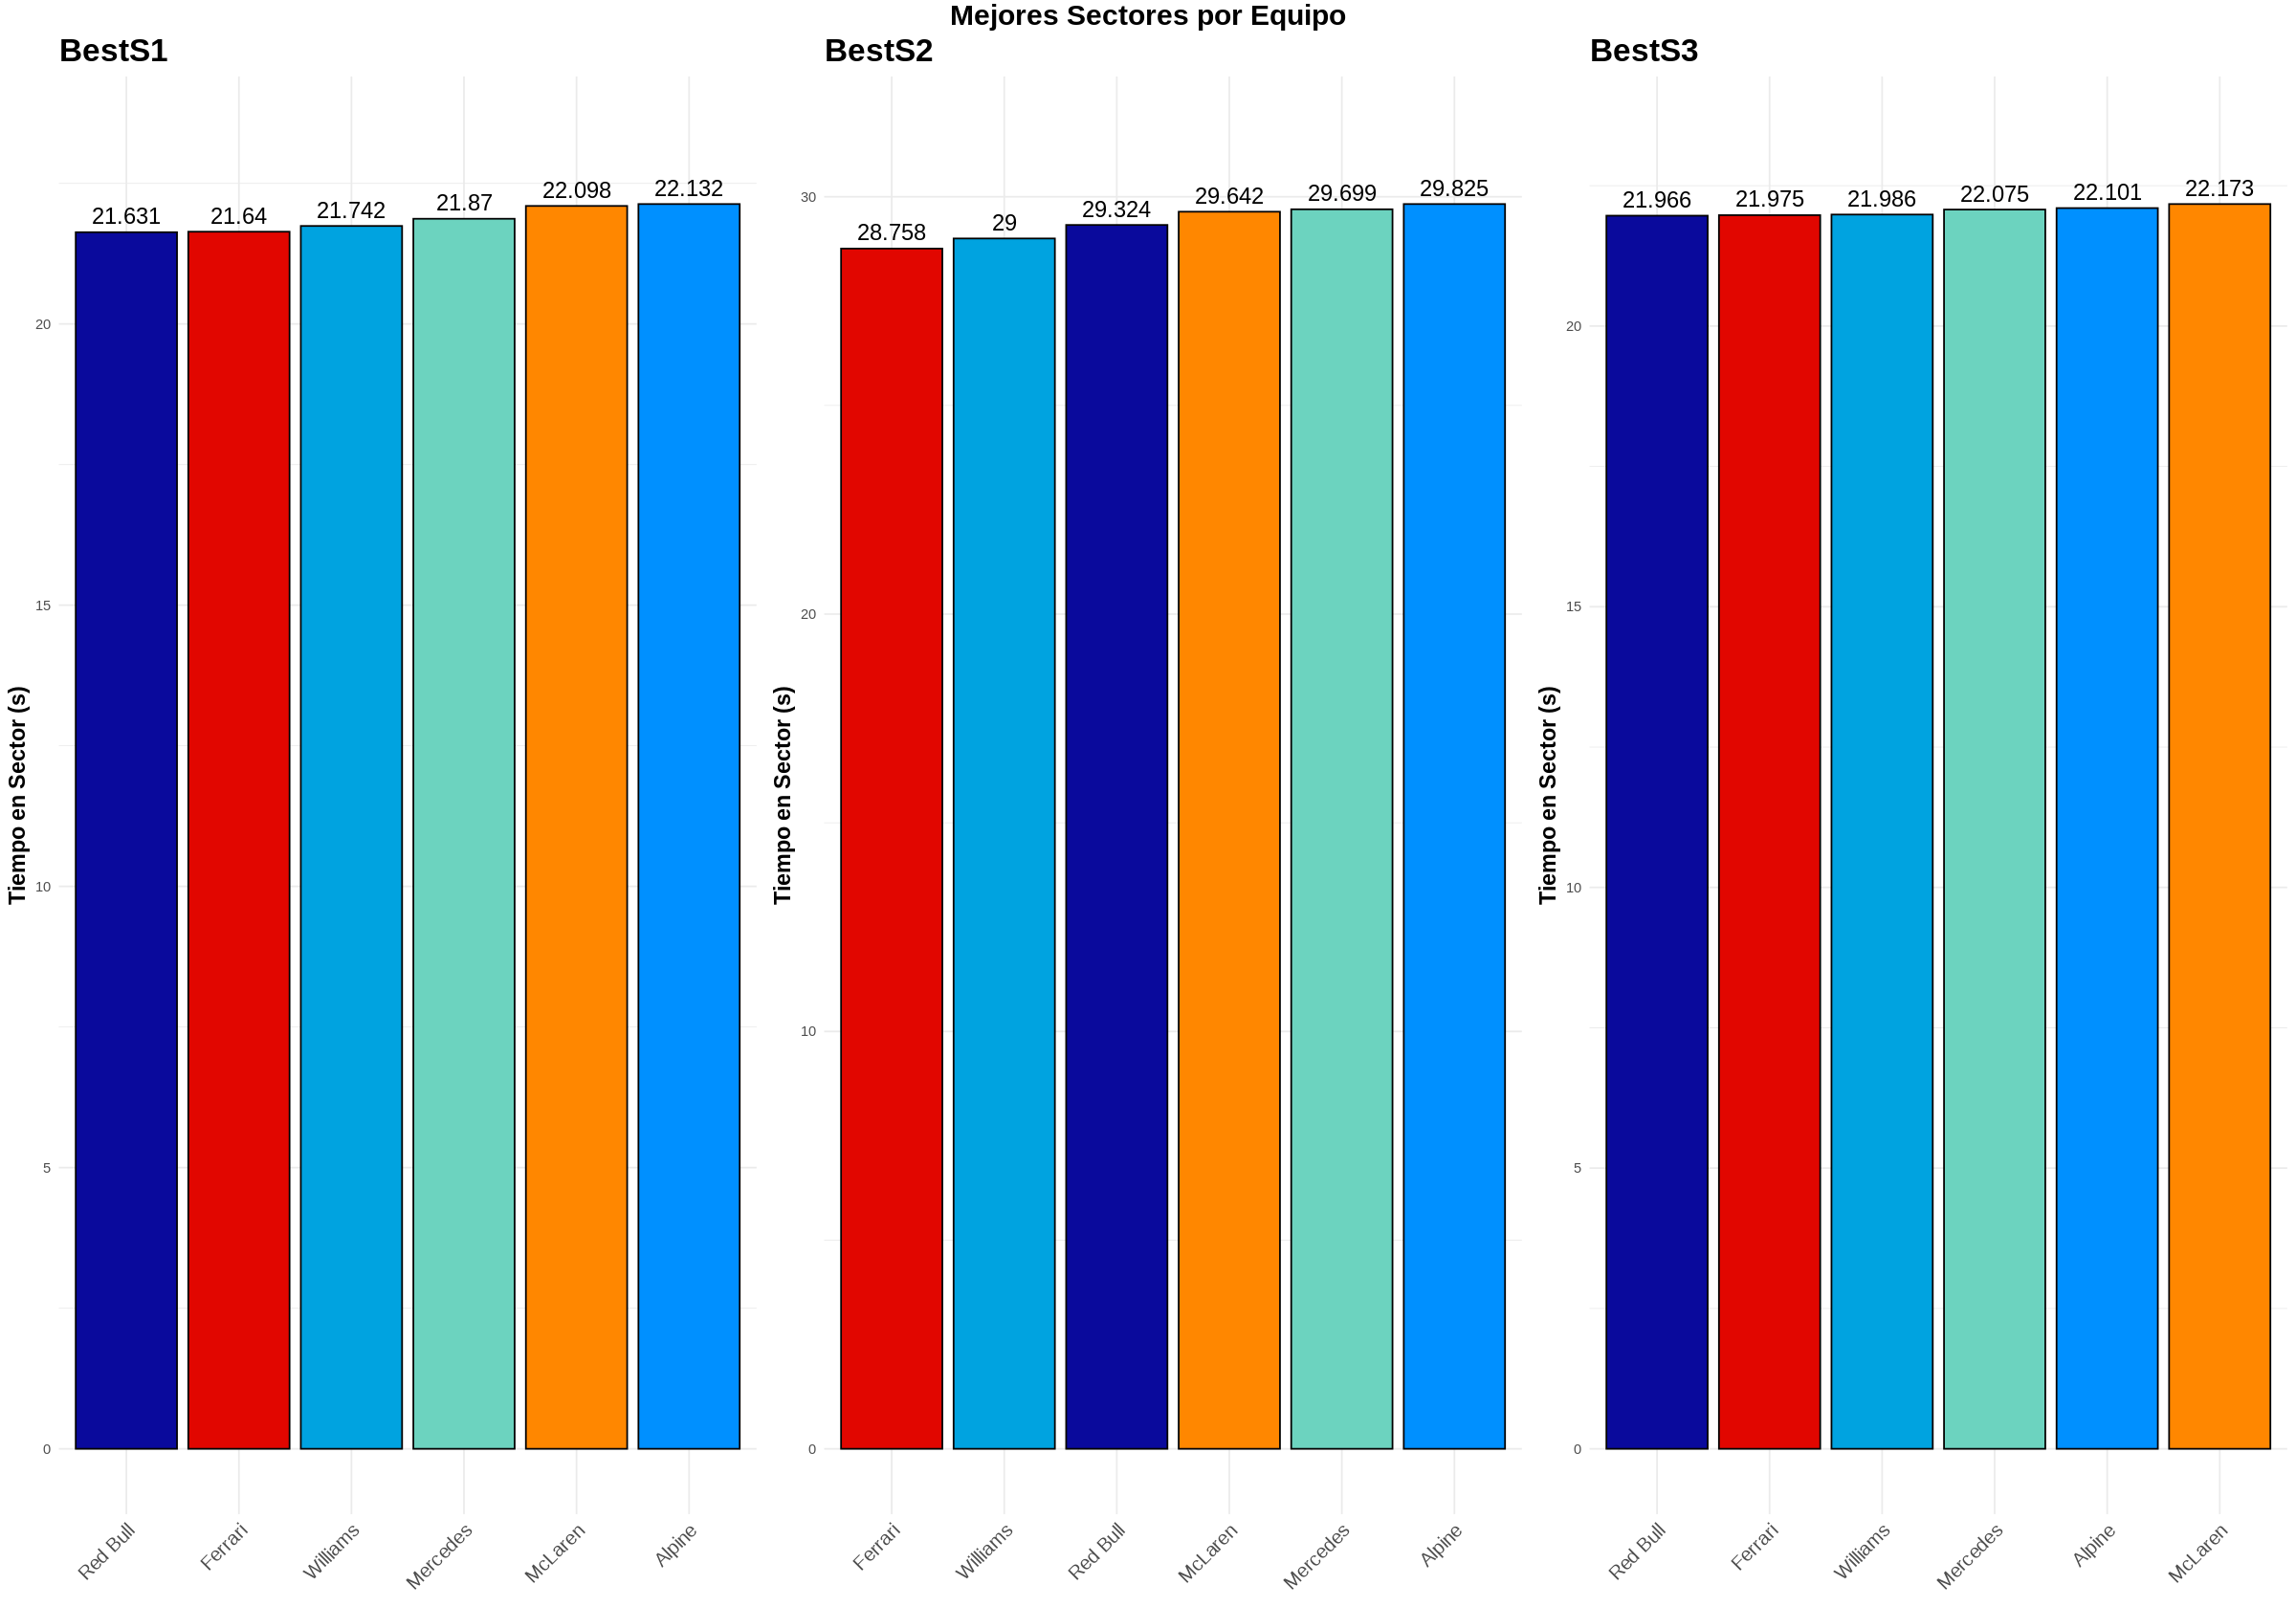

In [63]:
# Grafico 8
best_sector_times <- telemetria %>%
  group_by(carId, lap_number, sector) %>%
  summarise(
    sector_time = max(lap_time, na.rm = TRUE) - min(lap_time, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  group_by(carId, sector) %>%
  summarise(
    best_sector_time = min(sector_time, na.rm = TRUE),
    .groups = 'drop'
  )

# Define custom bright team colors (colores_f1)
colores_f1 <- c(
  "FER" = "#E10600",  # Ferrari Red
  "RED" = "#0A0A9C",  # Red Bull Navy Blue
  "MCL" = "#FF8700",  # McLaren Papaya Orange
  "MER" = "#6CD3BF",  # Mercedes Teal
  "ALP" = "#0090FF",  # Alpine Blue
  "WIL" = "#00A3E0"   # Williams Light Blue
)

# Create a mapping for full team names
full_team_names <- c(
  "FER" = "Ferrari",
  "RED" = "Red Bull",
  "MCL" = "McLaren",
  "MER" = "Mercedes",
  "ALP" = "Alpine",
  "WIL" = "Williams"
)

# Create tabla_mejores by pivoting wider
tabla_mejores <- best_sector_times %>%
  pivot_wider(names_from = sector, values_from = best_sector_time, names_prefix = "Best")

# Reshape to long format for plotting and add full team names
sectores_long <- tabla_mejores %>%
  select(carId, BestS1, BestS2, BestS3) %>%
  pivot_longer(cols = -carId, names_to = "Sector", values_to = "Tiempo") %>%
  mutate(full_carId = recode(carId, !!!full_team_names)) # Add full team names

# Function to plot each sector
plot_sector <- function(data, sec) {
  df_s <- data %>% filter(Sector == sec)
  ggplot(df_s, aes(x = reorder(full_carId, Tiempo), y = Tiempo, fill = carId)) +
    geom_col(color="black") +
    geom_text(aes(label=round(Tiempo,3)), vjust=-0.5, size=5) + # Increased size to 5
    scale_fill_manual(values = colores_f1) +
    coord_cartesian(ylim = c(0, max(df_s$Tiempo, na.rm = TRUE)*1.05)) +
    labs(title = sec, x = NULL, y = "Tiempo en Sector (s)") + # Changed y-axis label to be more descriptive
    theme_minimal() +
    theme(legend.position = "none",
          axis.text.x = element_text(angle = 45, hjust = 1, size = 12), # Increased x-axis text size to 12
          axis.title.y = element_text(size = 14, face = "bold"), # Increased y-axis title size and made bold
          plot.title = element_text(size = 20, face = "bold")) # Increased title size and made bold
}

cat("\n Generando Gráfico 7 (Sectores Separados)...\n")
p_s1 <- plot_sector(sectores_long, "BestS1")
p_s2 <- plot_sector(sectores_long, "BestS2")
p_s3 <- plot_sector(sectores_long, "BestS3")

# Arrange the plots with a larger main title
grid.arrange(p_s1, p_s2, p_s3, ncol = 3,
             top = textGrob("Mejores Sectores por Equipo",
                            gp = gpar(fontsize = 18, fontface = "bold")))

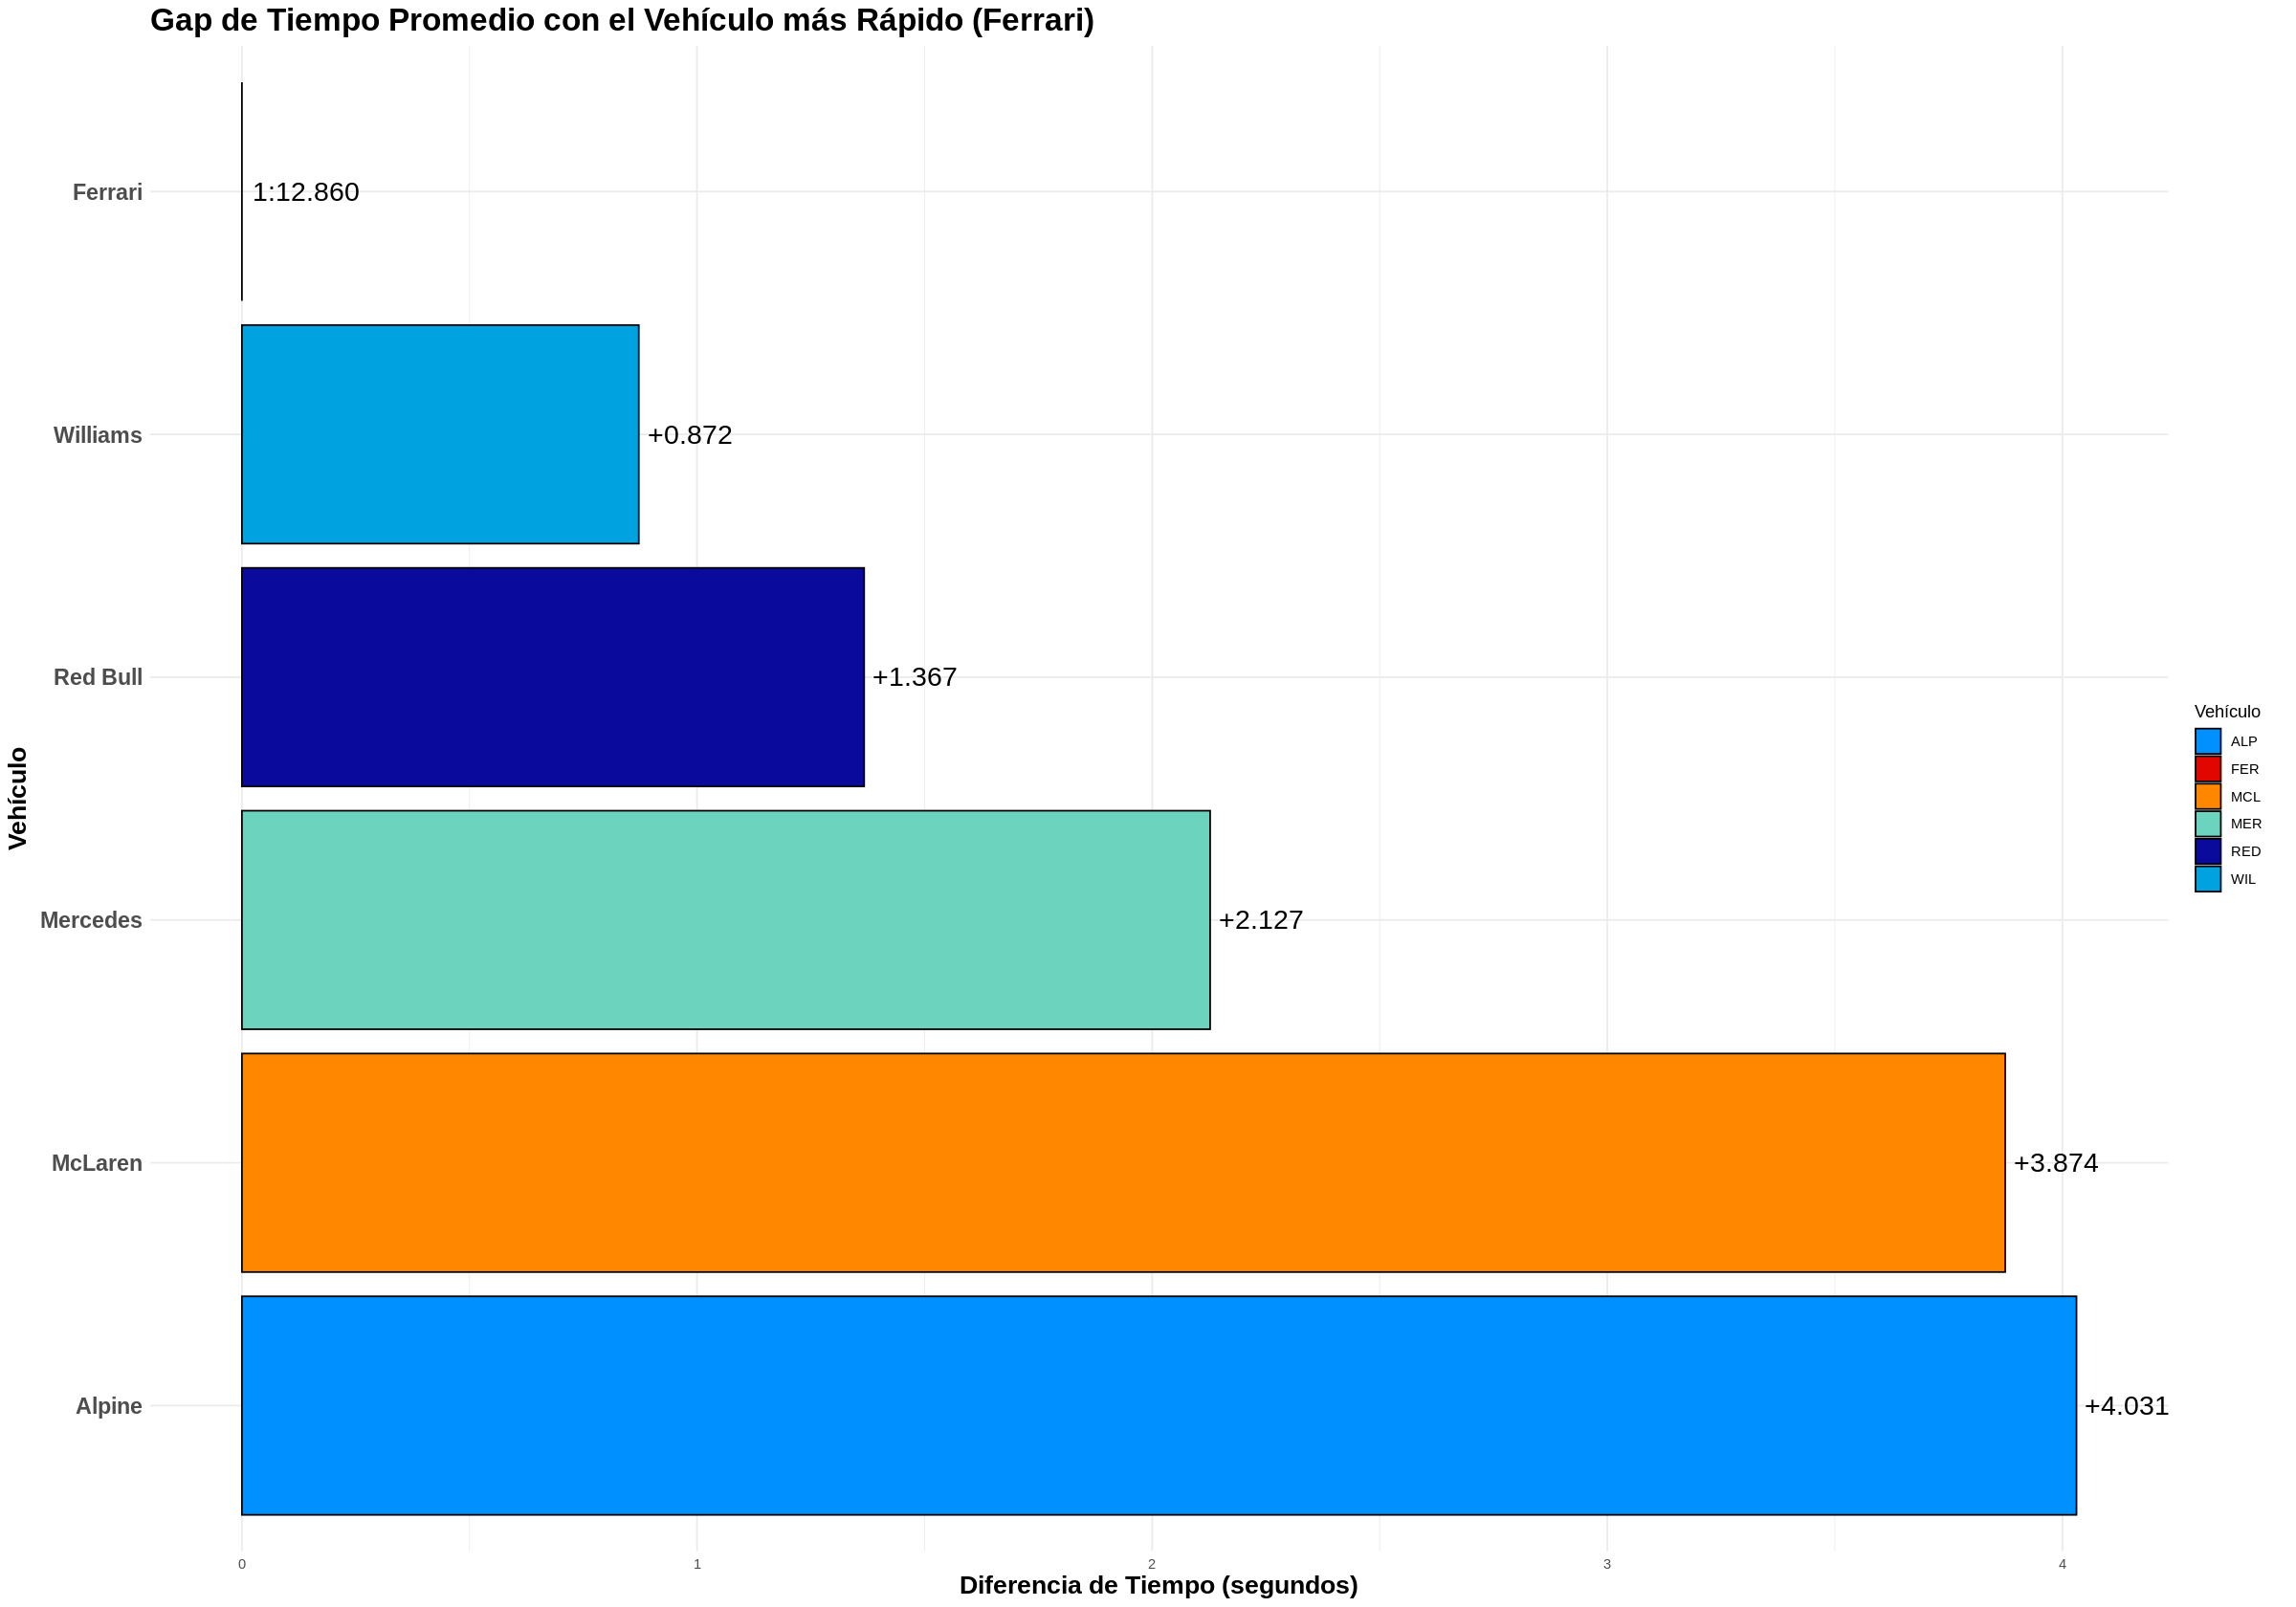

In [64]:
# Function to format seconds into M:SS.mmm
format_time_ms <- function(seconds) {
  minutes <- floor(seconds / 60)
  remaining_seconds <- seconds %% 60
  sprintf("%d:%06.3f", minutes, remaining_seconds)
}

# Calculate average lap time for each carId
average_lap_times <- telemetria %>%
  # Removed: filter(lap_time_invalid == 0) %>% # Filter out invalid lap times
  group_by(carId, lap_number) %>%
  summarise(total_lap_time = max(lap_time, na.rm = TRUE), .groups = 'drop') %>%
  group_by(carId) %>%
  summarise(avg_lap_time = mean(total_lap_time, na.rm = TRUE), .groups = 'drop')

# Identify the fastest vehicle
fastest_car_time <- min(average_lap_times$avg_lap_time, na.rm = TRUE)
fastest_car_id_abb <- average_lap_times %>%
  filter(avg_lap_time == fastest_car_time) %>%
  pull(carId) %>% head(1) # Get abbreviation for fastest car

# Define custom bright team colors (colores_f1)
colores_f1 <- c(
  "FER" = "#E10600",  # Ferrari Red
  "RED" = "#0A0A9C",  # Red Bull Navy Blue
  "MCL" = "#FF8700",  # McLaren Papaya Orange
  "MER" = "#6CD3BF",  # Mercedes Teal
  "ALP" = "#0090FF",  # Alpine Blue
  "WIL" = "#00A3E0"   # Williams Light Blue
)

# Create a mapping for full team names
full_team_names <- c(
  "FER" = "Ferrari",
  "RED" = "Red Bull",
  "MCL" = "McLaren",
  "MER" = "Mercedes",
  "ALP" = "Alpine",
  "WIL" = "Williams"
)

# Calculate the gap for each vehicle relative to the fastest
gap_data <- average_lap_times %>%
  mutate(gap_seconds = avg_lap_time - fastest_car_time) %>%
  mutate(full_carId = recode(carId, !!!full_team_names)) %>%
  arrange(gap_seconds) # Order by gap_seconds for plotting

# Get the full name and formatted time of the fastest car for the title and annotation
fastest_car_full_name <- full_team_names[fastest_car_id_abb]
fastest_car_time_formatted <- format_time_ms(fastest_car_time)

# Prepare labels: replace 0 gap with formatted fastest time, add '+' for others
gap_data <- gap_data %>%
  mutate(display_label = ifelse(gap_seconds == 0,
                                fastest_car_time_formatted,
                                paste0("+", as.character(round(gap_seconds, 3)))))

# Create the horizontal bar chart
ggplot(gap_data, aes(x = gap_seconds, y = reorder(full_carId, -gap_seconds), fill = carId)) +
  geom_bar(stat = "identity", color = "black") +
  geom_text(aes(label = display_label), hjust = -0.1, size = 6) + # Use display_label
  scale_fill_manual(values = colores_f1) +
  labs(
    title = paste0("Gap de Tiempo Promedio con el Vehículo más Rápido (", fastest_car_full_name, ")"),
    x = "Diferencia de Tiempo (segundos)",
    y = "Vehículo",
    fill = "Vehículo"
  ) +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 14, face = "bold"), # Enlarge and bold y-axis text
    axis.title.x = element_text(size = 16, face = "bold"), # Enlarge and bold x-axis title
    axis.title.y = element_text(size = 16, face = "bold"), # Enlarge and bold y-axis title
    plot.title = element_text(size = 20, face = "bold") # Enlarge and bold plot title
  )


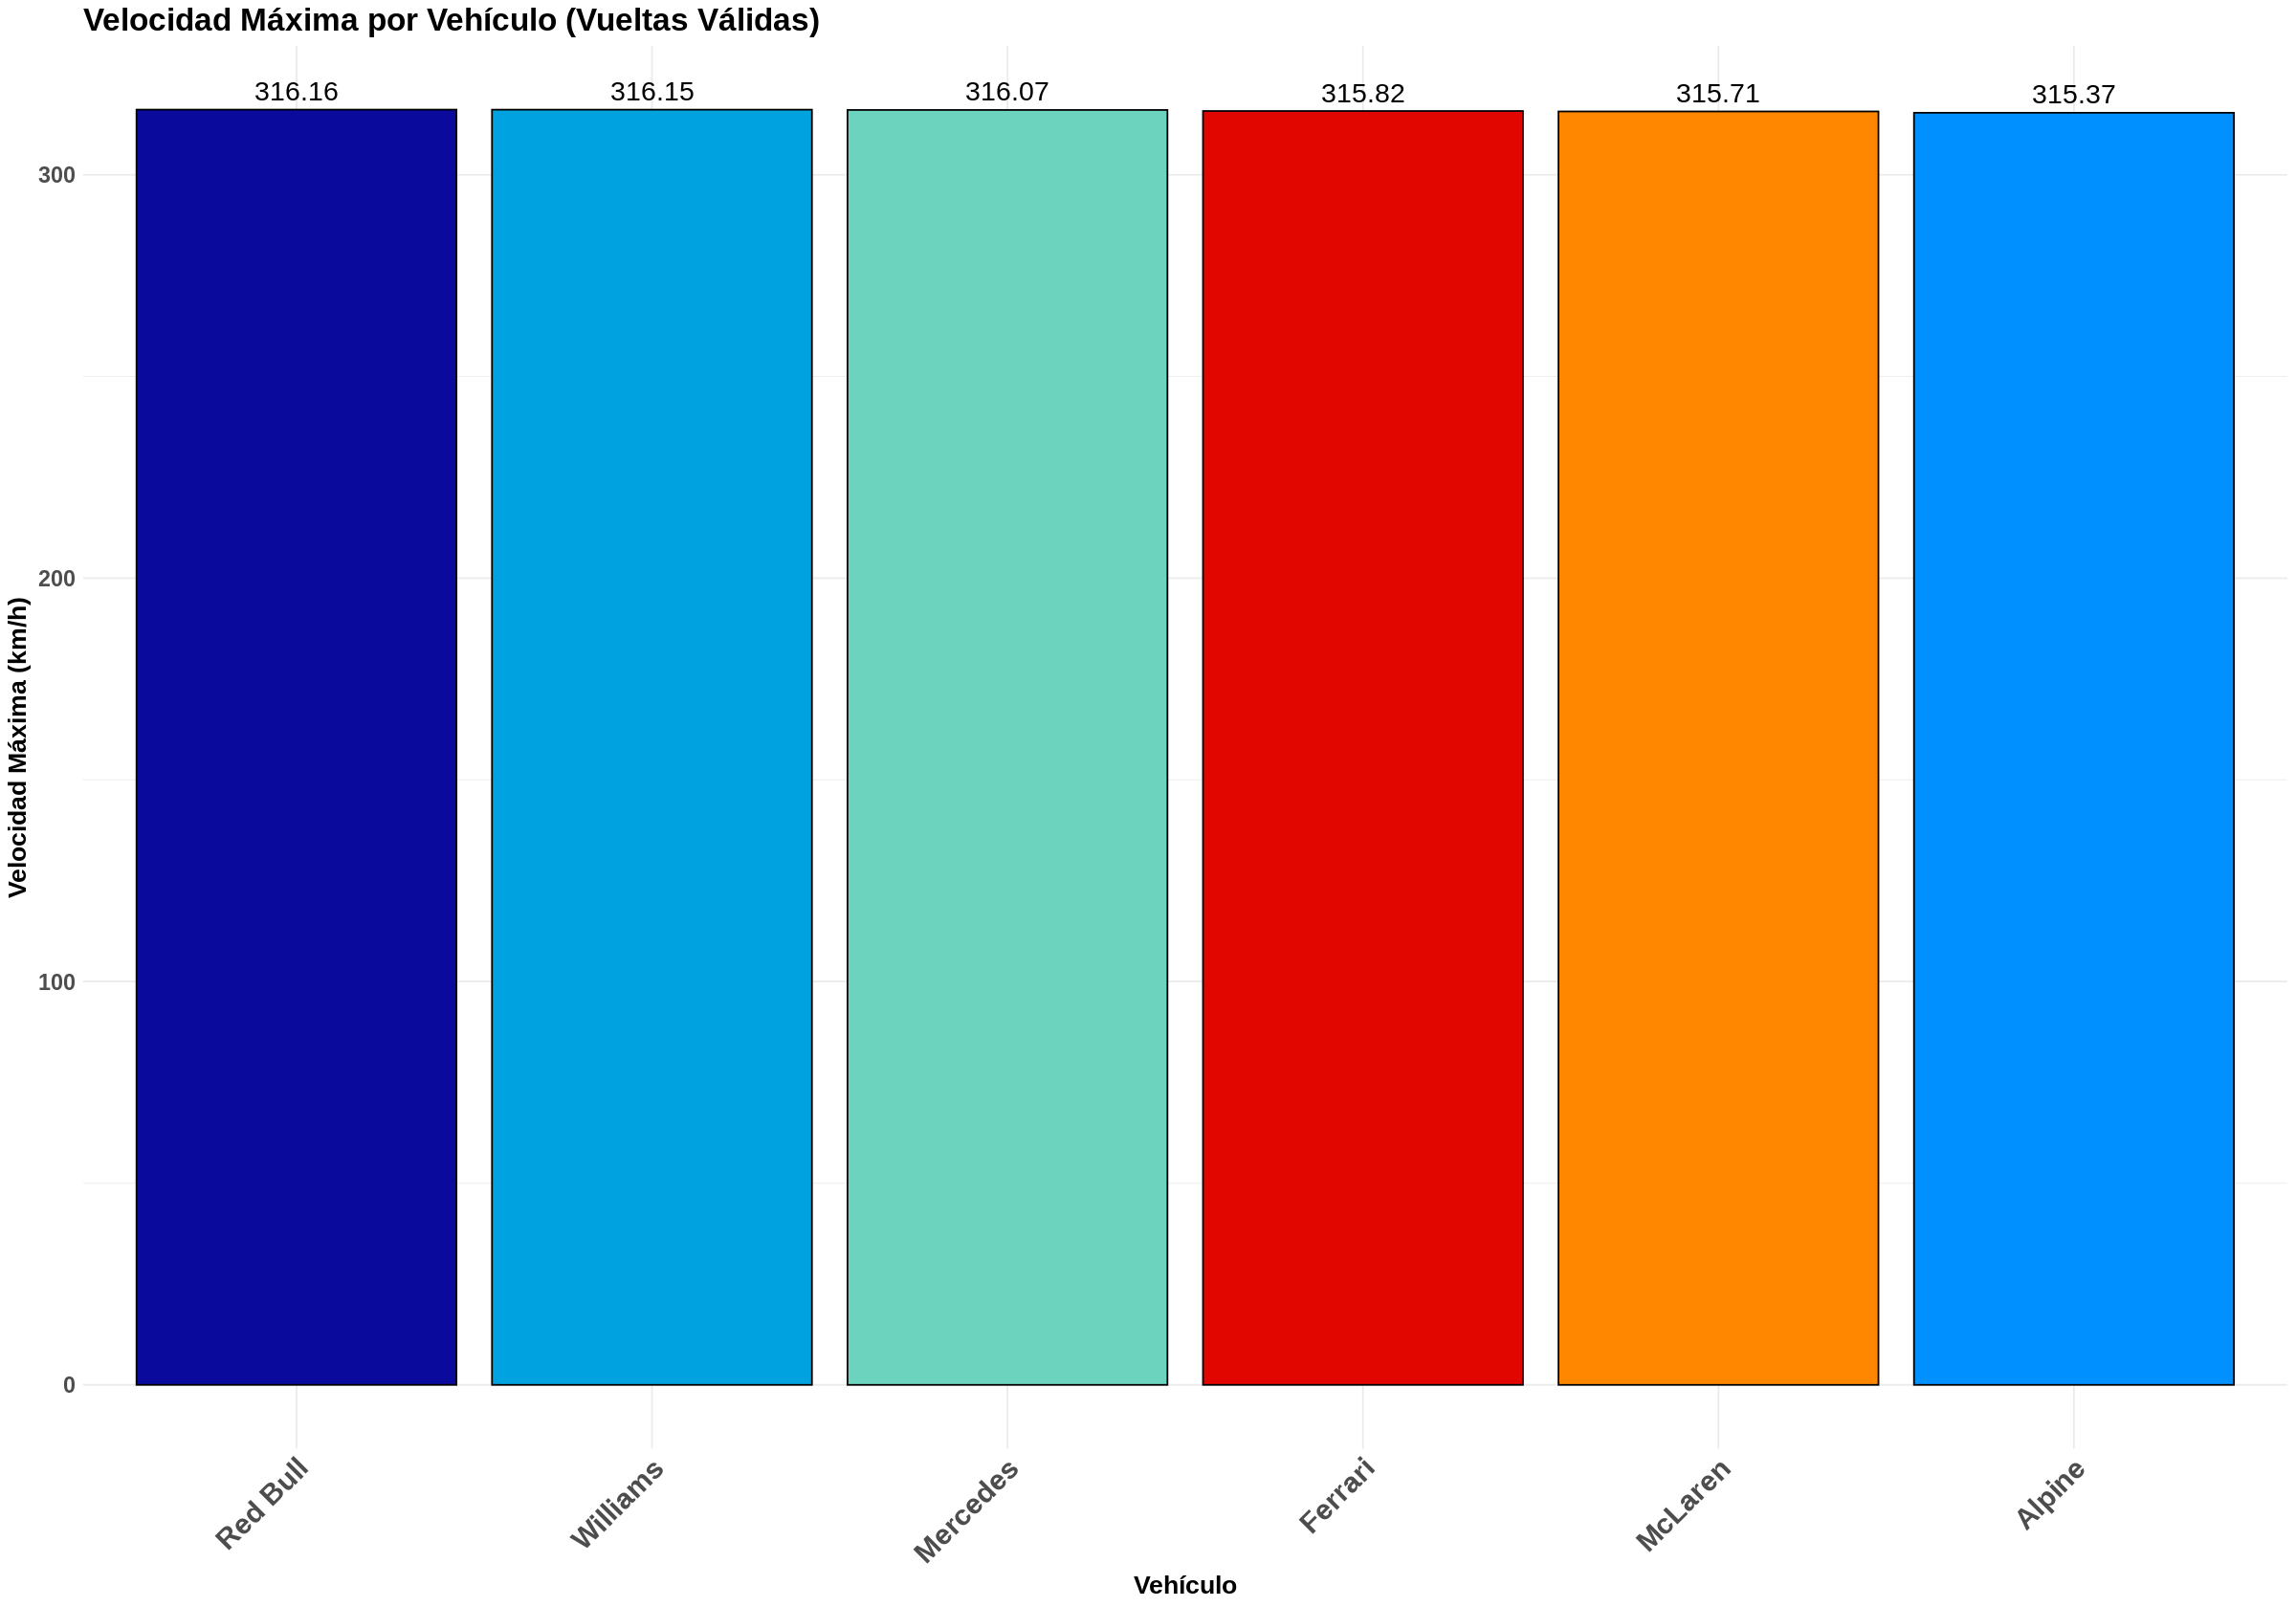

In [65]:
library(dplyr)
library(ggplot2)

# Calculate maximum velocity for each car, considering only valid laps
max_velocity_data <- telemetria %>%
  filter(lap_time_invalid == 0) %>% # Filter for valid laps only
  group_by(carId) %>%
  summarise(max_velocidad = max(velocidad, na.rm = TRUE), .groups = 'drop') %>%
  arrange(desc(max_velocidad)) # Order from fastest to slowest

# Define custom bright team colors (colores_f1)
colores_f1 <- c(
  "FER" = "#E10600",  # Ferrari Red
  "RED" = "#0A0A9C",  # Red Bull Navy Blue
  "MCL" = "#FF8700",  # McLaren Papaya Orange
  "MER" = "#6CD3BF",  # Mercedes Teal
  "ALP" = "#0090FF",  # Alpine Blue
  "WIL" = "#00A3E0"   # Williams Light Blue
)

# Create a mapping for full team names
full_team_names <- c(
  "FER" = "Ferrari",
  "RED" = "Red Bull",
  "MCL" = "McLaren",
  "MER" = "Mercedes",
  "ALP" = "Alpine",
  "WIL" = "Williams"
)

# Add full team names to the data and create an ordered factor for plotting
max_velocity_data <- max_velocity_data %>%
  mutate(full_carId = recode(carId, !!!full_team_names)) %>%
  mutate(full_carId = factor(full_carId, levels = unique(full_carId[order(-max_velocidad)]))) # Create ordered factor

# Create the bar chart for maximum velocity
ggplot(max_velocity_data, aes(x = full_carId, y = max_velocidad, fill = carId)) + # Use the ordered factor directly
  geom_col(color = "black") +
  geom_text(aes(label = round(max_velocidad, 2)), vjust = -0.5, size = 6) + # Display values on top of bars
  scale_fill_manual(values = colores_f1) +
  labs(
    title = "Velocidad Máxima por Vehículo (Vueltas Válidas)",
    x = "Vehículo",
    y = "Velocidad Máxima (km/h)", # Added km/h unit
    fill = "Vehículo"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 18, face = "bold"), # Increased x-axis text size
    axis.text.y = element_text(size = 14, face = "bold"), # Enlarge and bold y-axis text
    axis.title.x = element_text(size = 16, face = "bold"), # Enlarge and bold x-axis title
    axis.title.y = element_text(size = 16, face = "bold"), # Enlarge and bold y-axis title
    plot.title = element_text(size = 20, face = "bold"), # Enlarge and bold plot title
    legend.position = "none"
  )